In [5]:
from paddleocr import PaddleOCR
from pydantic import BaseModel
import cv2
import numpy as np


# # Initialize the OCR model; use GPU if available
# ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  # Use lang='ch' for Chinese, etc.

# # Specify the image path
# image_path = 'data/images/berserk.png'  # Replace with your image path

# # Perform OCR on the image
# result = ocr.ocr(image_path, cls=True)

# # Print the result
# for line in result:
#     for word_info in line:
#         print(f'Text: {word_info[1][0]}, Confidence: {word_info[1][1]}')

class OCR_Response(BaseModel):
    boxes: list
    texts: list




class OCR:
    def __init__(self):
        self.ocr = PaddleOCR(use_angle_cls=True, use_gpu=False, lang='en')  
    

    def get_ocr(self, image_path: str):
        """
        Performs OCR on the given image.

        Args:
            image_path (str): The path to the image.

        Returns:
            OCR_Response: An OCR_Response object containing the bounding boxes and texts.
        """
        result = self.ocr.ocr(image_path, cls=True)
        boxes = []
        texts = []
        for line in result:
            for word_info in line:
                boxes.append(word_info[0])
                texts.append(word_info[1][0])
        return OCR_Response(boxes=boxes, texts=texts)
    

ocr = OCR()
response = ocr.get_ocr('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/38.jpg')

# Load the image
image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/38.jpg')

# Draw boxes around the text data
for text, box in zip(response.texts, response.boxes):
    print(f'Text: {text}, Box: {box}')
    box = [tuple(map(int, point)) for point in box]
    cv2.polylines(image, [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=2)
    # Write the image with boxes to a file

[2024/10/19 14:06:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/razor/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/razor/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

In [139]:
image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/38.jpg')
from matplotlib.pylab import plt


merged_boxes = []


for text, box in zip(response.texts, response.boxes):

    box = [tuple(map(int, point)) for point in box]

    # Calculate the area of the bounding box
    area = cv2.contourArea(np.array(box))
    # Define the area threshold
    area_threshold = 100  # You can adjust this threshold as needed

    box = [tuple(map(int, point)) for point in box]
    x_average = 0
    y_average = 0

    for point in box:
        x_average += point[0]
        y_average += point[1]

    x_average = x_average / 4
    y_average = y_average / 4

    x_low = min([point[0] for point in box])
    y_low = min([point[1] for point in box])
    x_high = max([point[0] for point in box])
    y_high = max([point[1] for point in box])

    

    nearest_neighbor = None
    min_distance = float('inf')

    for mb in merged_boxes:
        distance = np.sqrt((mb[0] - x_average) ** 2 + (mb[1] - y_average) ** 2)
        if distance < min_distance:
            min_distance = distance
            nearest_neighbor = mb

    if nearest_neighbor and min_distance < 50:
        # print(f"Nearest Neighbor for {text} : {nearest_neighbor}, Distance: {min_distance}, Text {nearest_neighbor[2]}")
        if min_distance < 50:
            merged_boxes.remove(nearest_neighbor)
            merged_boxes.append([x_average, y_average, nearest_neighbor[2] + " " + text,  nearest_neighbor[3], nearest_neighbor[4], x_high, y_high])
        else:
            merged_boxes.append([x_average, y_average, text, x_low, y_low, x_high, y_high])
    else:
        # print(f"No Nearest Neighbor for {text}")
        merged_boxes.append([x_average, y_average, text, x_low, y_low, x_high, y_high])    


    

        # print(f"Text: {text}, Average X: {x_average}, Average Y: {y_average}")

        

    for box in merged_boxes:
        cv2.polylines(image, [np.array([(box[3], box[4]), (box[6], box[4]), (box[6], box[7]), (box[3], box[7])])], isClosed=True, color=(0, 255, 0), thickness=1)


for boxes in merged_boxes:
    print(boxes[2], end="\n")

plt.imshow(image)

IndexError: list index out of range

x_min: 733, y_min: 31, x_max: 789, y_max: 60, text: 10
x_min: 961, y_min: 24, x_max: 1039, y_max: 80, text: 00
x_min: 1639, y_min: 308, x_max: 1745, y_max: 386, text: RUNNING! IS 'SANDMAN' HEYLOOK
x_min: 1576, y_min: 372, x_max: 1631, y_max: 420, text: SOME! AWE
x_min: 126, y_min: 326, x_max: 213, y_max: 465, text: WEKAPIPO GUARD, THE ROYAL MEMBER OF HE'SA KNOWS. THAT GUY
x_min: 383, y_min: 377, x_max: 485, y_max: 458, text: THIS PATH? WE TAKEN TIMES HAVE HOW MANY
x_min: 1163, y_min: 363, x_max: 1256, y_max: 516, text: DRINKING. DAYS WITHOUT TOLAST3 HORSES HAVE HERE.THE THEM DRINK, CAN'TLET YOU STILL
x_min: 54, y_min: 818, x_max: 70, y_max: 837, text: D
x_min: 1461, y_min: 778, x_max: 1508, y_max: 924, text: TIM. MOUNTAIN TOWIN, FAVORITE DANGEROUS THHWOST FIRST,
x_min: 565, y_min: 831, x_max: 630, y_max: 972, text: ALIVE? I SI THAT? HE13S THE WHAT
x_min: 720, y_min: 866, x_max: 782, y_max: 1012, text: THEY AREN'T CREEPY, FAMILY. BOOORRoM THE GUYS ARE THOSE
x_min: 796, y_min: 993, x_max

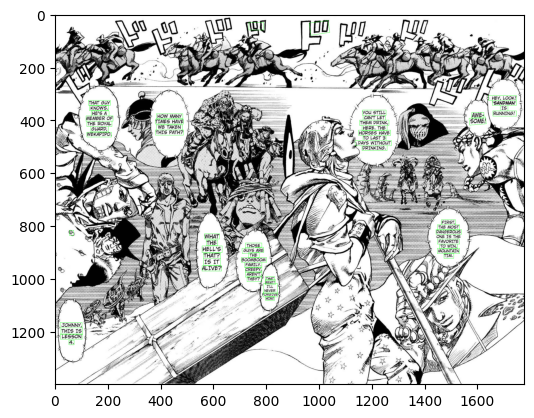

In [91]:
def intersecting_boxes(box1, box2):
    """
    Checks if two boxes intersect.

    Args:
        box1 (list): The first box.
        box2 (list): The second box.

    Returns:
        bool: True if the boxes intersect, False otherwise.
    """


    acord1, acord2, acord3, acord4 = box1.boxes
    bcord1, bcord2, bcord3, bcord4 = box2.boxes

    box_1_y_average = (acord1[1] + acord4[1]) / 4
    box_2_y_average = (bcord1[1] + bcord4[1]) / 4

    box_1_x_average = (acord1[0] + acord2[0]) / 4
    box_2_x_average = (bcord1[0] + bcord2[0]) / 4

    print()




    if(abs(box_1_y_average - box_2_y_average) > 25 and abs(box_1_x_average - box_2_x_average) > 1):
        return False
    else:
        return True
    


def merge_boxes(box1, box2):
    """
    Merges two boxes.

    Args:
        box1 (list): The first box.
        box2 (list): The second box.

    Returns:
        list: The merged box.
    """

    acord1, acord2, acord3, acord4 = box1
    bcord1, bcord2, bcord3, bcord4 = box2

    x1 = min(acord1[0], acord2[0], acord3[0], acord4[0], bcord1[0], bcord2[0], bcord3[0], bcord4[0])
    x2 = max(acord1[0], acord2[0], acord3[0], acord4[0], bcord1[0], bcord2[0], bcord3[0], bcord4[0])
    y1 = min(acord1[1], acord2[1], acord3[1], acord4[1], bcord1[1], bcord2[1], bcord3[1], bcord4[1])
    y2 = max(acord1[1], acord2[1], acord3[1], acord4[1], bcord1[1], bcord2[1], bcord3[1], bcord4[1])

    return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

def merge_intersecting_boxes(boxes):
    """
    Merges intersecting boxes.

    Args:
        boxes (list): A list of boxes.

    Returns:
        list: A list of merged boxes.
    """
    merged_boxes = []
    for box in boxes:
        if not merged_boxes:
            merged_boxes.append(box)
        else:
            intersecting = False
            for i, merged_box in enumerate(merged_boxes):
                if intersecting_boxes(merged_box, box):
                    merged_boxes[i] = merge_boxes(merged_box, box)
                    intersecting = True
                    break
            if not intersecting:
                merged_boxes.append(box)
    return merged_boxes

intersecting_boxes(response[0], response[1])

TypeError: 'OCR_Response' object is not subscriptable

x_min: 733, y_min: 31, x_max: 789, y_max: 60, text: 10
x_min: 961, y_min: 24, x_max: 1039, y_max: 80, text: 00
x_min: 1639, y_min: 308, x_max: 1745, y_max: 386, text: RUNNING! IS 'SANDMAN' HEYLOOK
x_min: 1576, y_min: 372, x_max: 1631, y_max: 420, text: SOME! AWE
x_min: 126, y_min: 326, x_max: 213, y_max: 465, text: WEKAPIPO GUARD, THE ROYAL MEMBER OF HE'SA KNOWS. THAT GUY
x_min: 383, y_min: 377, x_max: 485, y_max: 458, text: THIS PATH? WE TAKEN TIMES HAVE HOW MANY
x_min: 1163, y_min: 363, x_max: 1256, y_max: 516, text: DRINKING. DAYS WITHOUT TOLAST3 HORSES HAVE HERE.THE THEM DRINK, CAN'TLET YOU STILL
x_min: 54, y_min: 818, x_max: 70, y_max: 837, text: D
x_min: 1461, y_min: 778, x_max: 1508, y_max: 924, text: TIM. MOUNTAIN TOWIN, FAVORITE DANGEROUS THHWOST FIRST,
x_min: 565, y_min: 831, x_max: 630, y_max: 972, text: ALIVE? I SI THAT? HE13S THE WHAT
x_min: 720, y_min: 866, x_max: 782, y_max: 1012, text: THEY AREN'T CREEPY, FAMILY. BOOORRoM THE GUYS ARE THOSE
x_min: 796, y_min: 993, x_max

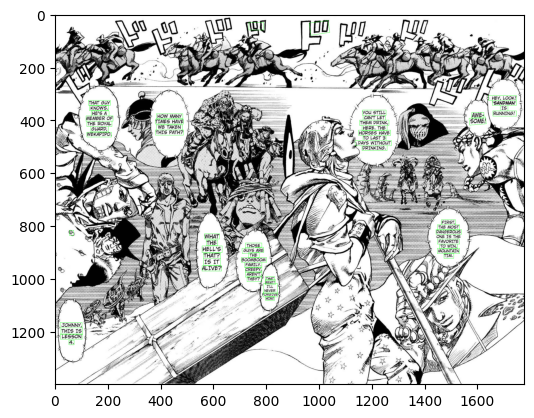

In [129]:
import cv2
import numpy as np
from matplotlib.pylab import plt
from collections import namedtuple

# Define a namedtuple for merged boxes
MergedBox = namedtuple('MergedBox', ['x_avg', 'y_avg', 'x_min', 'y_min', 'x_max', 'y_max', 'text'])

image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/38.jpg')

merged_boxes = []

for text, box in zip(response.texts, response.boxes):
    box = [tuple(map(int, point)) for point in box]

    # Calculate the area of the bounding box
    area = cv2.contourArea(np.array(box))
    # Define the area threshold
    area_threshold = 100  # You can adjust this threshold as needed

    # Calculate the average x and y coordinates of the box
    x_avg = sum([point[0] for point in box]) / 4
    y_avg = sum([point[1] for point in box]) / 4

    # Get the min and max values for x and y coordinates
    x_min = min([point[0] for point in box])
    x_max = max([point[0] for point in box])
    y_min = min([point[1] for point in box])
    y_max = max([point[1] for point in box])

    nearest_neighbor = None
    min_distance = float('inf')

    for mb in merged_boxes:
        distance = np.sqrt((mb.x_avg - x_avg) ** 2 + (mb.y_avg - y_avg) ** 2)
        if distance < min_distance:
            min_distance = distance
            nearest_neighbor = mb

    if nearest_neighbor and min_distance < 50:
        # If the nearest neighbor is within the threshold, merge the text
        merged_boxes.remove(nearest_neighbor)
        merged_boxes.append(MergedBox(x_avg, y_avg, nearest_neighbor.x_min, nearest_neighbor.y_min, x_max, y_max, text + " " + nearest_neighbor.text))
    else:
        # If no neighbor or distance is too far, add a new box
        merged_boxes.append(MergedBox(x_avg, y_avg, x_min, y_min, x_max, y_max, text))

    # Draw the bounding box on the image
    cv2.polylines(image, [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=1)

# Print merged boxes with descriptive names
for box in merged_boxes:
    print(f"x_min: {box.x_min}, y_min: {box.y_min}, x_max: {box.x_max}, y_max: {box.y_max}, text: {box.text}")

plt.imshow(image)


[(733.0, 24.0), (1039.0, 24.0), (1039.0, 80.0), (733.0, 80.0)]
[(117.0, 308.0), (1745.0, 308.0), (1745.0, 421.0), (117.0, 421.0)]
[(120.0, 405.0), (1272.0, 405.0), (1272.0, 498.0), (120.0, 498.0)]
[[1161.0, 498.0], [1256.0, 498.0], [1256.0, 516.0], [1161.0, 516.0]]
[(54.0, 778.0), (1537.0, 778.0), (1537.0, 870.0), (54.0, 870.0)]
[(556.0, 855.0), (1530.0, 855.0), (1530.0, 959.0), (556.0, 959.0)]
[(556.0, 952.0), (841.0, 952.0), (841.0, 1057.0), (556.0, 1057.0)]
[(787.0, 1052.0), (841.0, 1052.0), (841.0, 1083.0), (787.0, 1083.0)]
[(19.0, 1167.0), (104.0, 1167.0), (104.0, 1251.0), (19.0, 1251.0)]


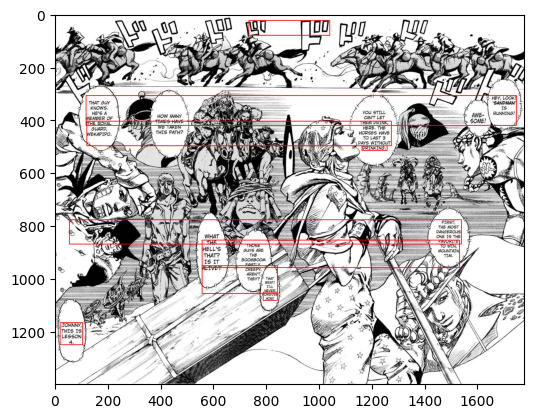

In [87]:
# Loop through each box and draw it on the image


image = cv2.imread('../data/images/jojo-no-kimyou-na-bouken-part-7-steel-ball-run-chapter-95/38.jpg')
for box in merged_boxes:
    a, b, c, d = box  # Unpacking the box coordinates
    ycoords = [a[1], b[1], c[1], d[1]]  # Y-coordinates of the box corners
    xcoords = [a[0], b[0], c[0], d[0]]  # X-coordinates of the box corners

    # Calculate the width and height of the bounding box
    width = max(xcoords) - min(xcoords)
    height = max(ycoords) - min(ycoords)


    print(box)  # Optional: print the box coordinates for debugging
    # Draw the rectangle on the image
    cv2.rectangle(image, (int(min(xcoords)), int(min(ycoords))), 
                    (int(max(xcoords)), int(max(ycoords))), 
                    (255, 0, 0), 2)  # Green boxes with thickness 2

import matplotlib.pyplot as plt
plt.imshow(image)